The following example shows how to train a model. Get a list of training data csv file in the selected folder. Lessons learned so far:
- Training result is very sensitive to normalization. The normalization approach based on mean and variance does not work very well. Still need to manually set mean and variance.
- t-sne plot of adapter trace is an important flag of training result. 
- h net does not have to descent because phi net training strives to make it rise, while h net training itself tries to lower the loss
- Increase the h training frequency to fight against rising h 
- Increase alpha to push domain info to adapter
- Increase number of features to minimize MSE loss.
- ocassional small spike in cross entropy loss is possibly a sign that phi net become further domain invariant and may not be bad.
- at the late stage of training while both mse loss and cross entropy loss converge. May need to train h net every step to refine the optimization direction.
- Do not need to select the model at the end epoch. Select the epoch when the loss is reasonably low and stable. 
- RMS is a good indicator because it matches the least square form of loss function
- When the residual force is small, e.g. training disturbance force compensated by BEMT, disturbance normalization should scale up the label for better learning. 

Existing problem:
- The more classes, the harder to train. The difficulty comes from instability of loss_f and loss_c. alpha is hard to tune.
- t-sne gets worse as epoch grows and the cross entropy loss remains the same. 

In [1]:
import os
import matplotlib.pyplot as plt

import training_manager

current_dir = os.getcwd()
training_subfolder = "wind_near_wall_bemt_fitting"
# training_subfolder = "wind_near_wall_bemt_fitting_zero"
# training_subfolder = "nf_training_back2back"
# validation_subfolder = "nf_validation_back2back"
validation_subfolder = "wind_near_wall_bemt_fitting_validation"
# validation_subfolder = "wind_near_wall_bemt_fitting_validation_sinusoidal"
# validation_subfolder = "wind_near_wall_bemt_fitting_zero_validation"

def generate_data_list(subfolder):
    """
    Generate a list of data files in the specified subfolder.
    """
    folder_path = os.path.join(os.path.dirname(current_dir), "data", "training", subfolder)
    file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Filter out files that do not end with .csv
    file_names = [f for f in file_names if f.endswith('.csv')]
    # add subfolder to the file names
    data_list = [os.path.join(subfolder, f) for f in file_names]
    return data_list

data_list = generate_data_list(training_subfolder)
print("Training Data List:")
for data in data_list:
    print(data)

validation_list = generate_data_list(validation_subfolder)
print("\nValidation Data List:")
for data in validation_list:
    print(data)

path1 = os.path.join(training_subfolder, "input_label_map_disturbance_force_label.yaml")

Training Data List:
wind_near_wall_bemt_fitting\test_wind_near_wall_x0_0_y0_0_z0_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting\test_wind_near_wall_x0_0_y0_0_z5_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting\test_wind_near_wall_x0_0_y0_0_zn5_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting\test_wind_near_wall_xn3_0_y0_0_z0_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting\test_wind_near_wall_xn3_0_y0_0_z5_0_d100_4_fitting.csv
wind_near_wall_bemt_fitting\test_wind_near_wall_xn3_0_y0_0_zn5_0_d100_4_fitting.csv

Validation Data List:
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_z10_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_z1_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_z4_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_zn10_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_

- Make sure the input_label_map_disturbance_force_label.yaml is in the selected folder. This yaml defines which fields are model inputs and which fields are data labels. 
- Make sure the column_map.yaml is in the selected folder. This yaml maps data fields to the corresponding column in the csv files. This file can be auto-generated by `Simulation\simulation\training_data_user_guide.ipynb`
- If this is the first time to train on this data. The script will normalize the data and save the normalization parameters into a file.

Setting up data factory...
Loading normalization params file from
..\data\training\wind_near_wall_bemt_fitting\normalization_params.yaml
Using 1501 samples from the dataset for training from source file: wind_near_wall_bemt_fitting\test_wind_near_wall_x0_0_y0_0_z0_0_d100_4_fitting.csv
Using 1501 samples from the dataset for training from source file: wind_near_wall_bemt_fitting\test_wind_near_wall_x0_0_y0_0_z5_0_d100_4_fitting.csv
Using 1501 samples from the dataset for training from source file: wind_near_wall_bemt_fitting\test_wind_near_wall_x0_0_y0_0_zn5_0_d100_4_fitting.csv
Using 1501 samples from the dataset for training from source file: wind_near_wall_bemt_fitting\test_wind_near_wall_xn3_0_y0_0_z0_0_d100_4_fitting.csv
Using 1501 samples from the dataset for training from source file: wind_near_wall_bemt_fitting\test_wind_near_wall_xn3_0_y0_0_z5_0_d100_4_fitting.csv
Using 1501 samples from the dataset for training from source file: wind_near_wall_bemt_fitting\test_wind_near_wall_

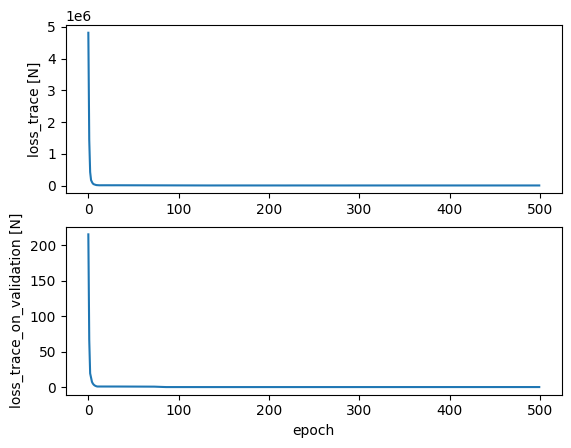

In [2]:
# use the data from previous section to train the model

factory = training_manager.PipelineFactory(is_diaml=False)
manager = factory.make_training_pipeline()
manager.set_up(
    training_data_menu=data_list,
    # training_data_menu=data_list[:4],    # use small data list for quick testing
    validation_data_menu=validation_list[-1:],
    input_label_map_file=path1,
    can_inspect_data=False
)
plt.show() 
manager.train()

plt.show()  

Inspect data in the data list.

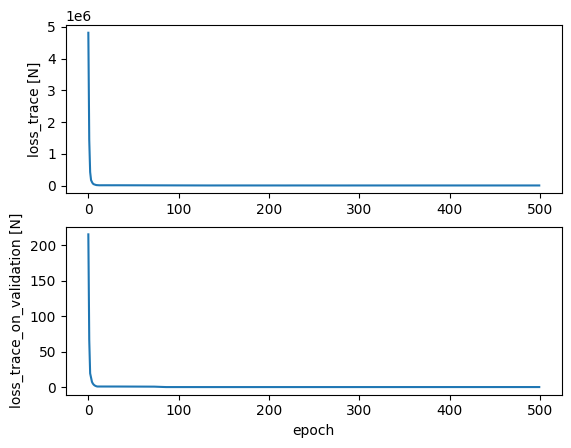

In [3]:
# trainer_instance.inspect_data(data_list[:2])
manager.show_result_only()

After training, we can save the model in the following way.

In [4]:
model_name = training_subfolder
manager.save_model(model_name)

Model saved to model\wind_near_wall_bemt_fitting.pth


Test the model using the test set.

test Data List:
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_z10_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_z1_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_z4_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_zn10_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_zn1_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_x0_0_y0_0_zn4_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_xn2_0_y0_0_z10_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_xn2_0_y0_0_z1_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wall_xn2_0_y0_0_z4_0_d0_5_validation_no_bemt.csv
wind_near_wall_bemt_fitting_validation\test_wind_near_wal

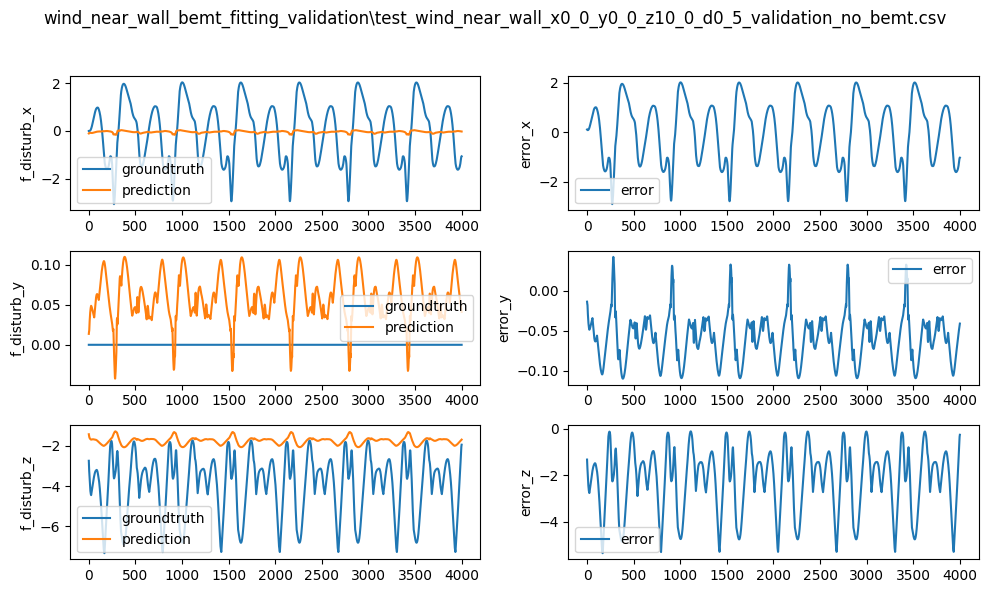

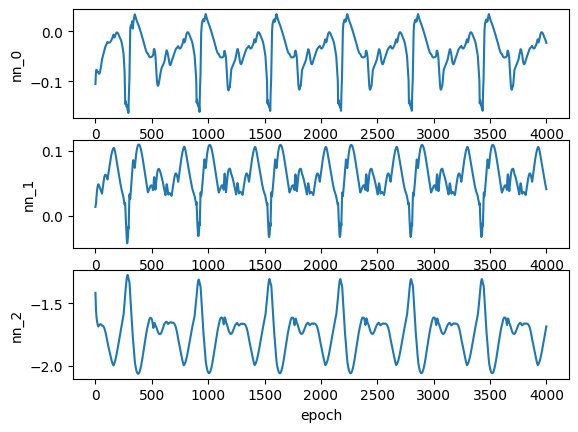

prediction: tensor([[-0.0096,  0.0104, -1.3175],
        [-0.0095,  0.0114, -1.3236],
        [-0.0098,  0.0124, -1.3290],
        ...,
        [-0.0357, -0.0087, -1.1677],
        [-0.0370, -0.0092, -1.1631],
        [-0.0383, -0.0097, -1.1586]])


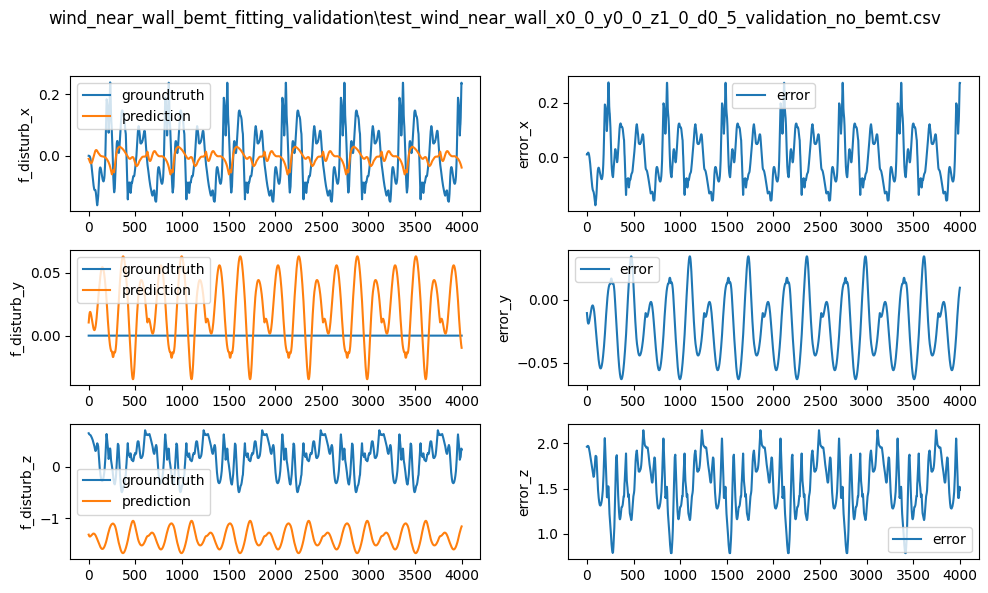

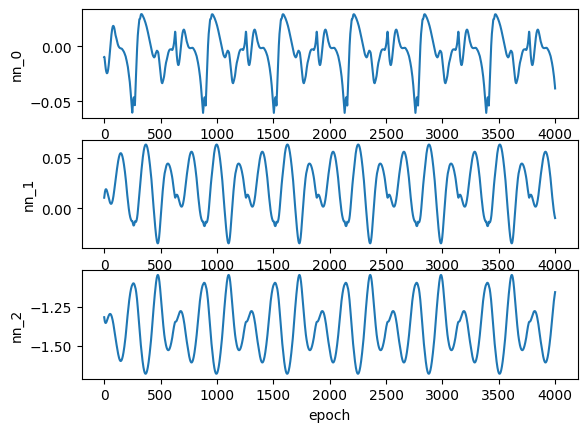

prediction: tensor([[ 0.0047,  0.0239, -1.4177],
        [ 0.0052,  0.0255, -1.4277],
        [ 0.0051,  0.0270, -1.4368],
        ...,
        [-0.0164,  0.0108, -1.3112],
        [-0.0175,  0.0103, -1.3067],
        [-0.0187,  0.0099, -1.3024]])


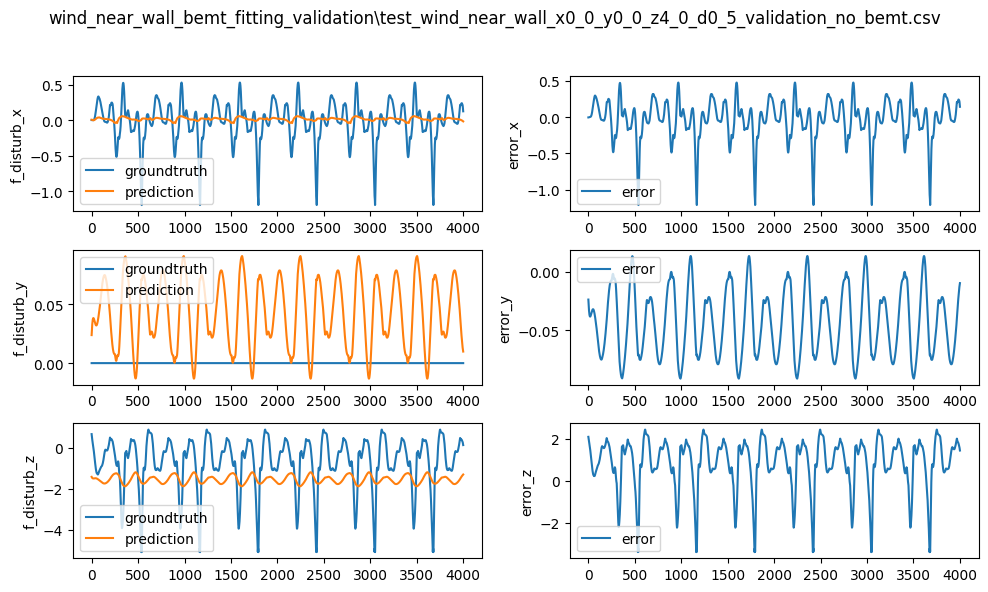

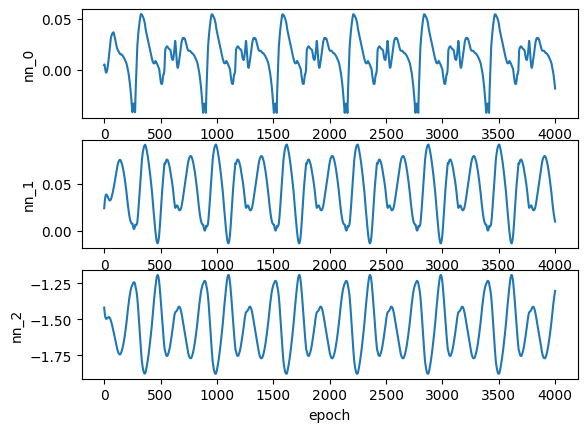

prediction: tensor([[-0.0623, -0.0389, -0.9505],
        [-0.0616, -0.0366, -0.9655],
        [-0.0613, -0.0344, -0.9786],
        ...,
        [-0.0816, -0.0381, -0.9304],
        [-0.0827, -0.0387, -0.9254],
        [-0.0837, -0.0393, -0.9206]])


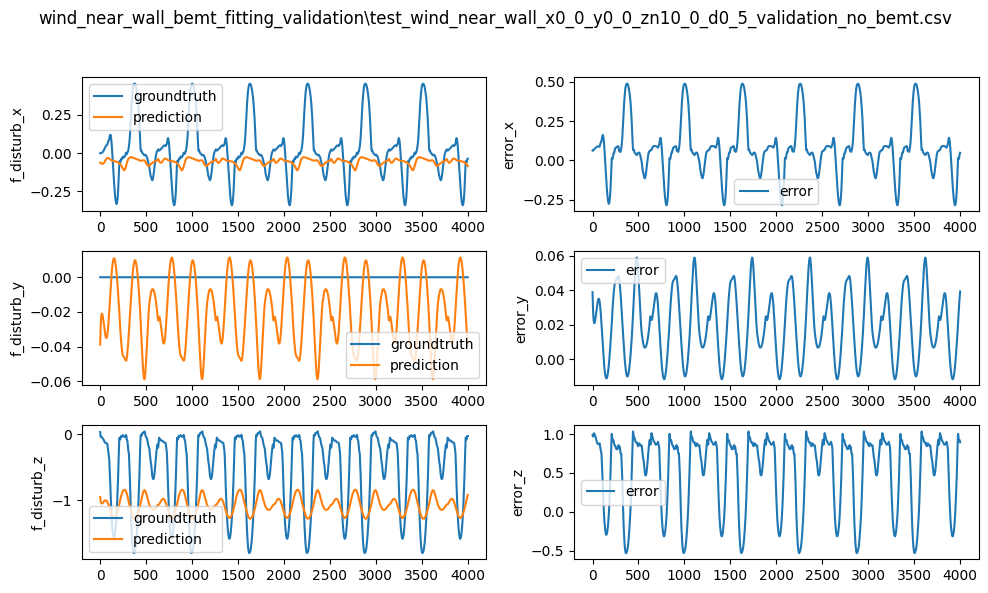

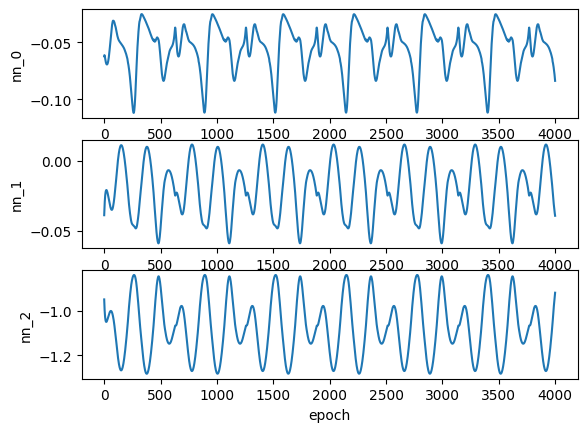

prediction: tensor([[-0.0192,  0.0015, -1.2507],
        [-0.0194,  0.0018, -1.2522],
        [-0.0200,  0.0021, -1.2537],
        ...,
        [-0.0436, -0.0182, -1.1003],
        [-0.0448, -0.0186, -1.0960],
        [-0.0460, -0.0190, -1.0918]])


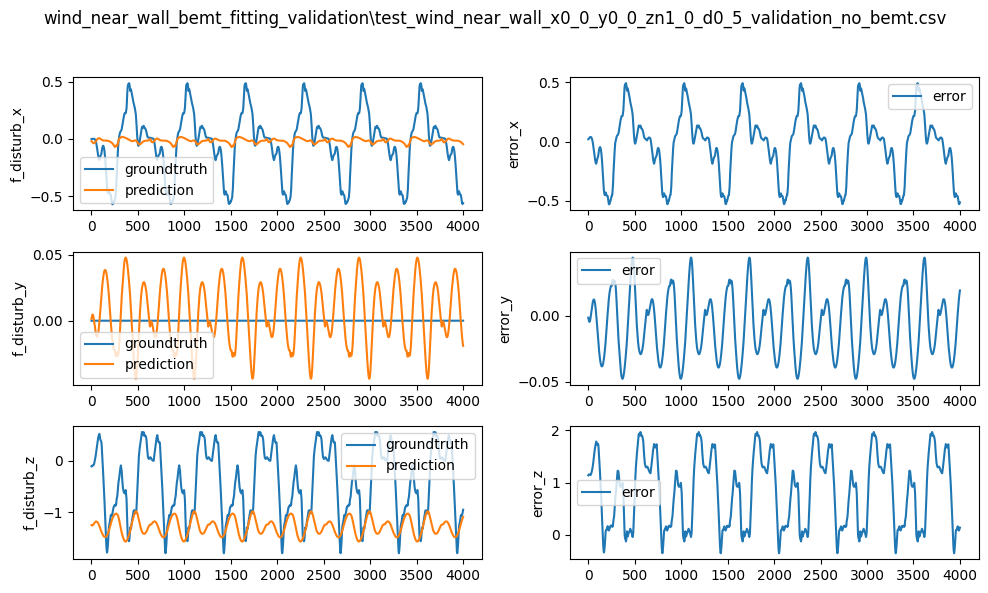

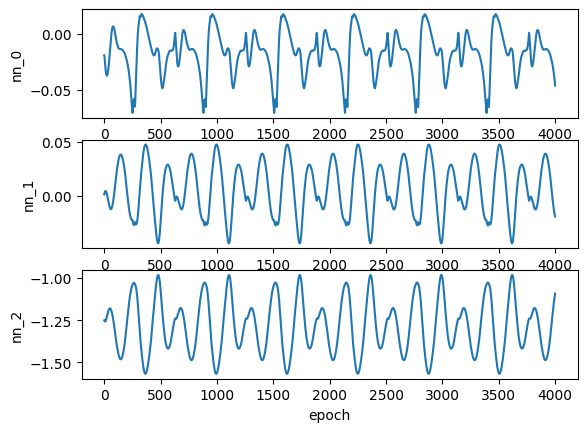

prediction: tensor([[-0.0336, -0.0120, -1.1506],
        [-0.0337, -0.0116, -1.1529],
        [-0.0342, -0.0111, -1.1550],
        ...,
        [-0.0564, -0.0273, -1.0286],
        [-0.0574, -0.0278, -1.0243],
        [-0.0584, -0.0282, -1.0201]])


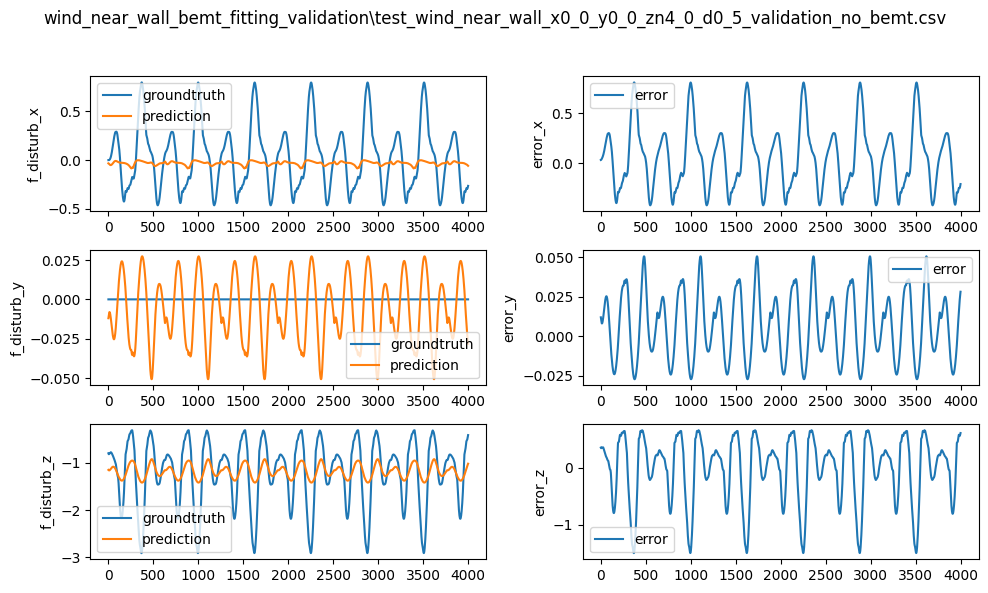

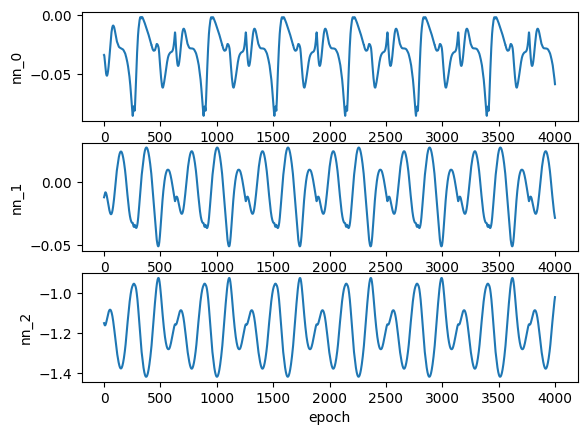

prediction: tensor([[-0.0990,  0.0114, -1.4152],
        [-0.0940,  0.0109, -1.4479],
        [-0.0897,  0.0103, -1.4770],
        ...,
        [-0.0217,  0.0431, -1.6877],
        [-0.0225,  0.0424, -1.6833],
        [-0.0235,  0.0417, -1.6790]])


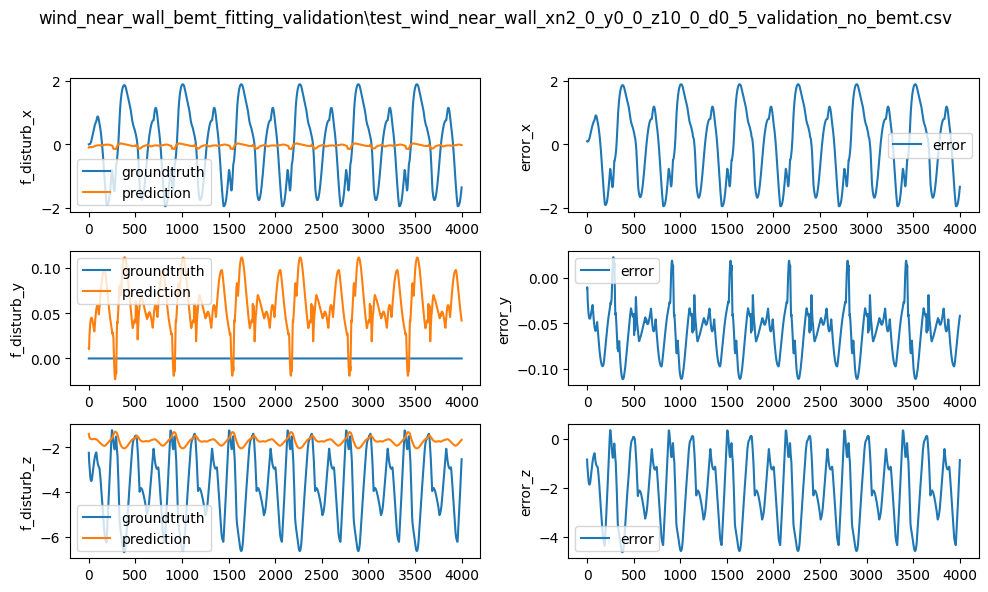

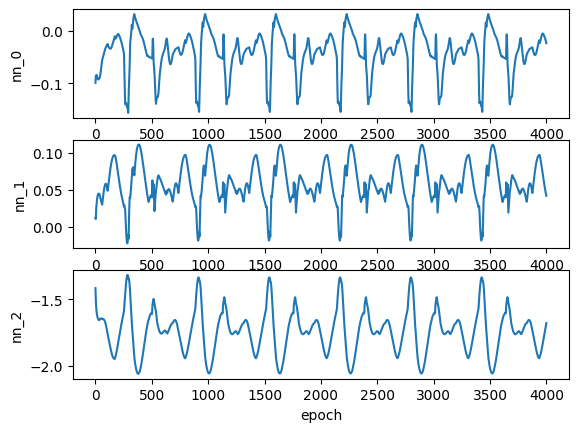

prediction: tensor([[-0.0089,  0.0097, -1.3138],
        [-0.0100,  0.0112, -1.3215],
        [-0.0111,  0.0125, -1.3282],
        ...,
        [-0.0340, -0.0057, -1.1882],
        [-0.0351, -0.0062, -1.1835],
        [-0.0362, -0.0067, -1.1791]])


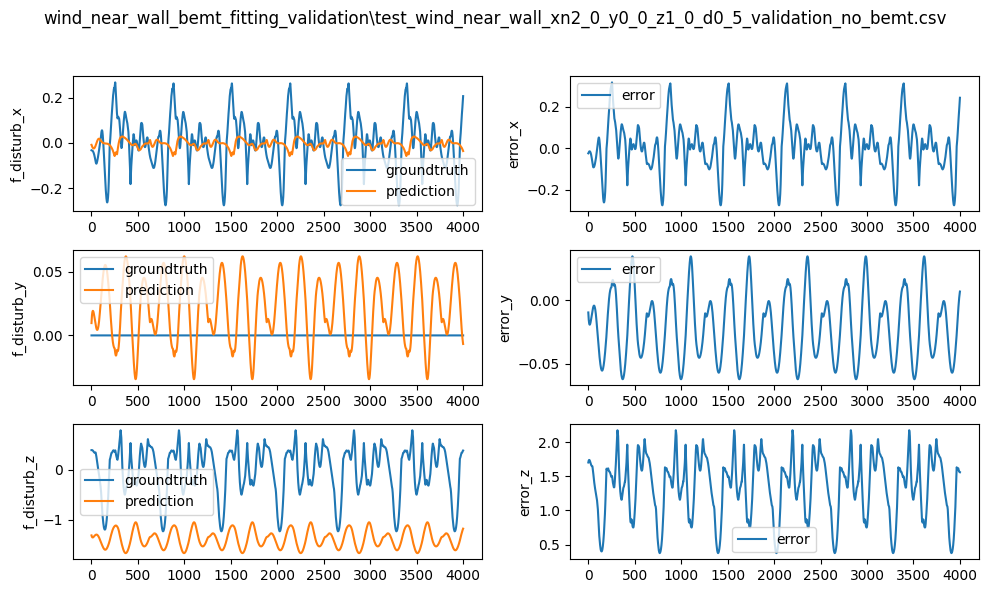

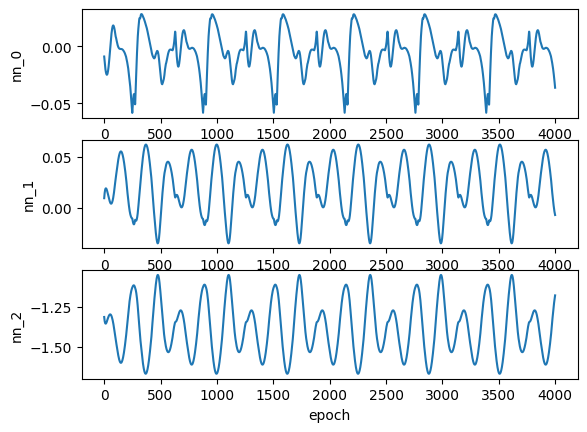

prediction: tensor([[ 0.0055,  0.0231, -1.4140],
        [ 0.0051,  0.0257, -1.4291],
        [ 0.0046,  0.0280, -1.4423],
        ...,
        [-0.0159,  0.0125, -1.3219],
        [-0.0174,  0.0121, -1.3173],
        [-0.0191,  0.0117, -1.3130]])


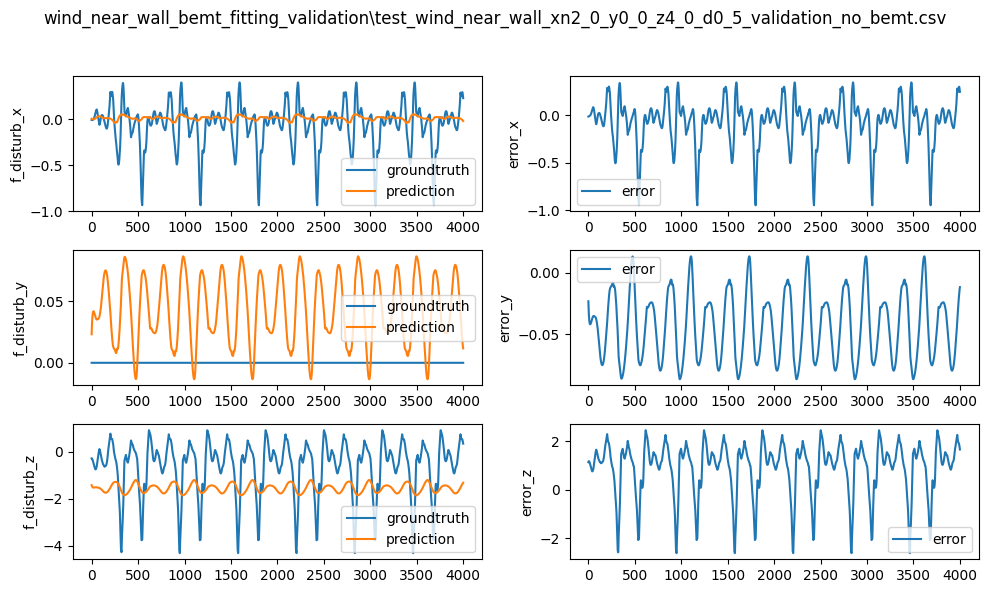

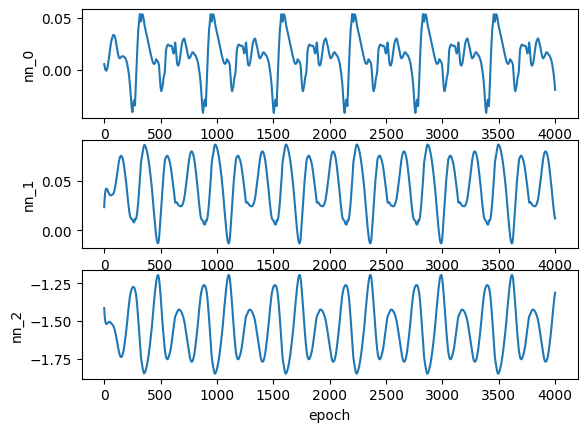

prediction: tensor([[-0.0616, -0.0396, -0.9467],
        [-0.0629, -0.0367, -0.9630],
        [-0.0641, -0.0342, -0.9767],
        ...,
        [-0.0840, -0.0405, -0.9125],
        [-0.0850, -0.0411, -0.9076],
        [-0.0858, -0.0418, -0.9025]])


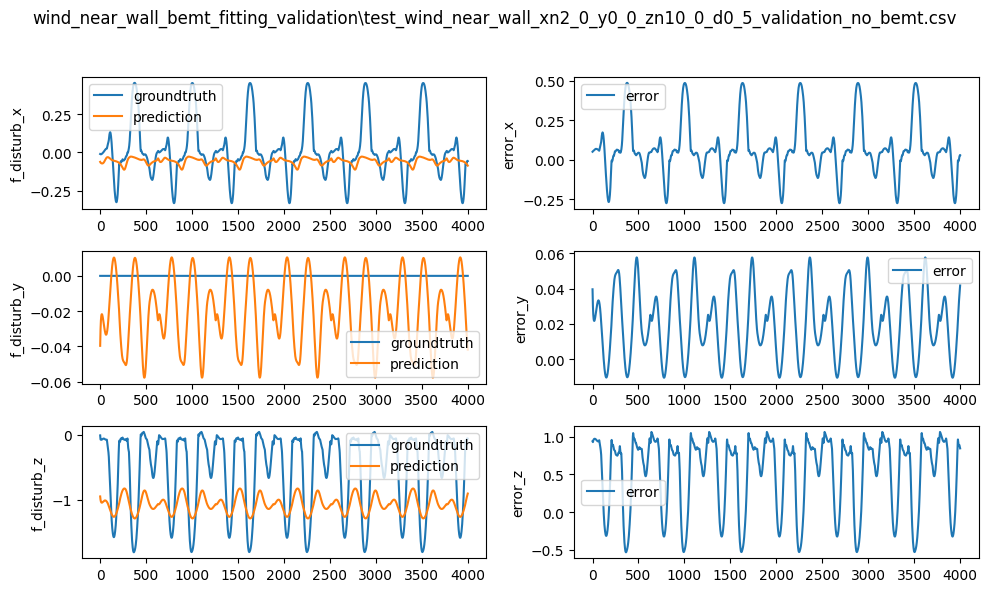

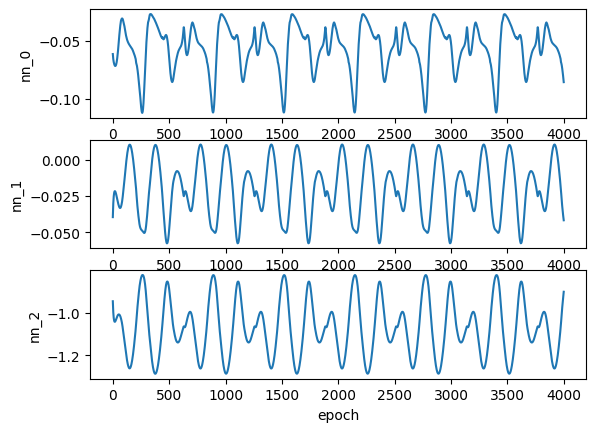

prediction: tensor([[-1.8484e-02,  7.0002e-04, -1.2470e+00],
        [-1.9949e-02,  1.5381e-03, -1.2502e+00],
        [-2.1379e-02,  2.2724e-03, -1.2528e+00],
        ...,
        [-4.5033e-02, -1.8420e-02, -1.0968e+00],
        [-4.6261e-02, -1.8893e-02, -1.0924e+00],
        [-4.7478e-02, -1.9345e-02, -1.0881e+00]])


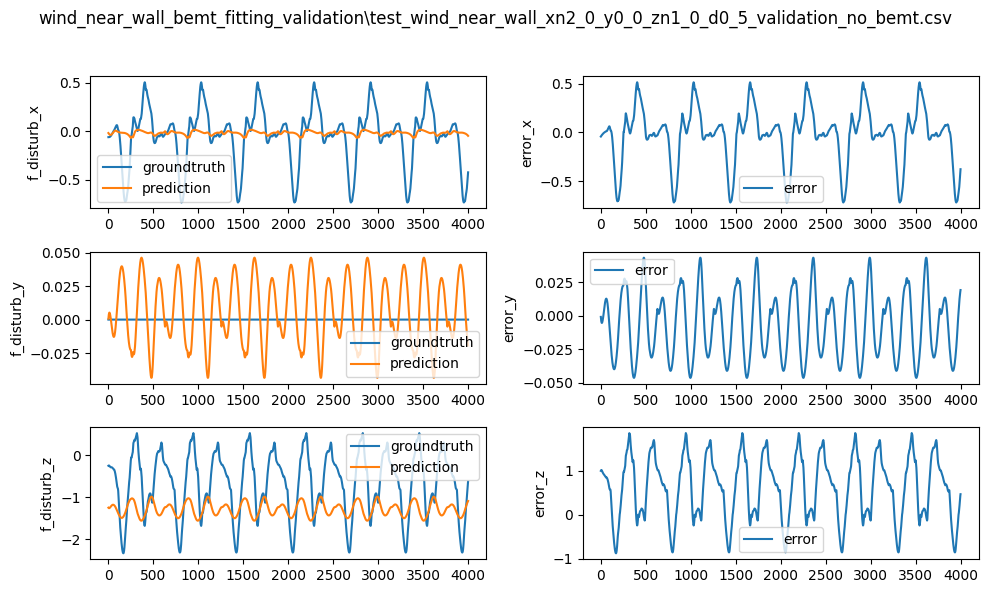

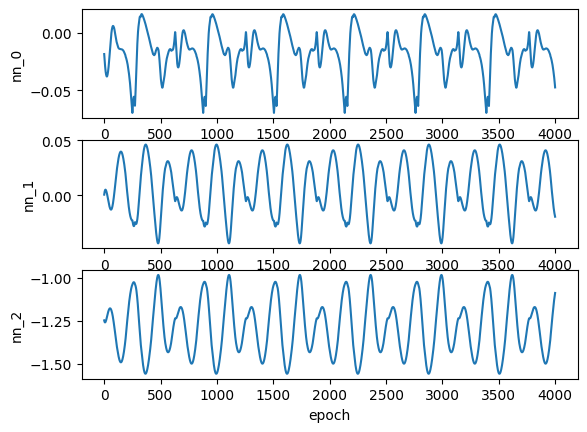

prediction: tensor([[-0.0329, -0.0128, -1.1469],
        [-0.0346, -0.0117, -1.1508],
        [-0.0363, -0.0109, -1.1540],
        ...,
        [-0.0581, -0.0292, -1.0148],
        [-0.0591, -0.0297, -1.0105],
        [-0.0604, -0.0301, -1.0061]])


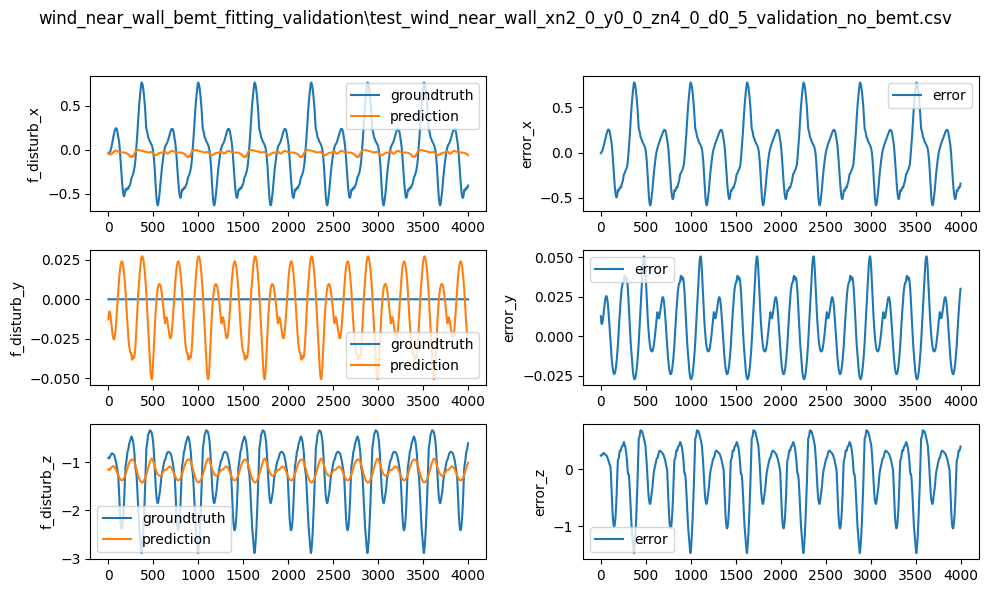

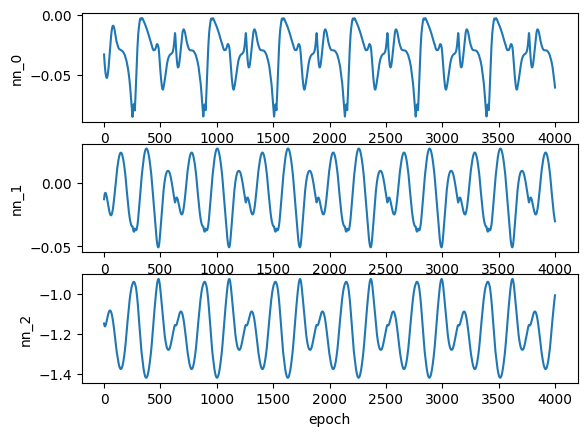

prediction: tensor([[-0.0894,  0.0080, -1.4149],
        [-0.0878,  0.0033, -1.4497],
        [-0.0900,  0.0065, -1.4729],
        ...,
        [-0.0264,  0.0440, -1.6761],
        [-0.0271,  0.0433, -1.6719],
        [-0.0279,  0.0425, -1.6677]])


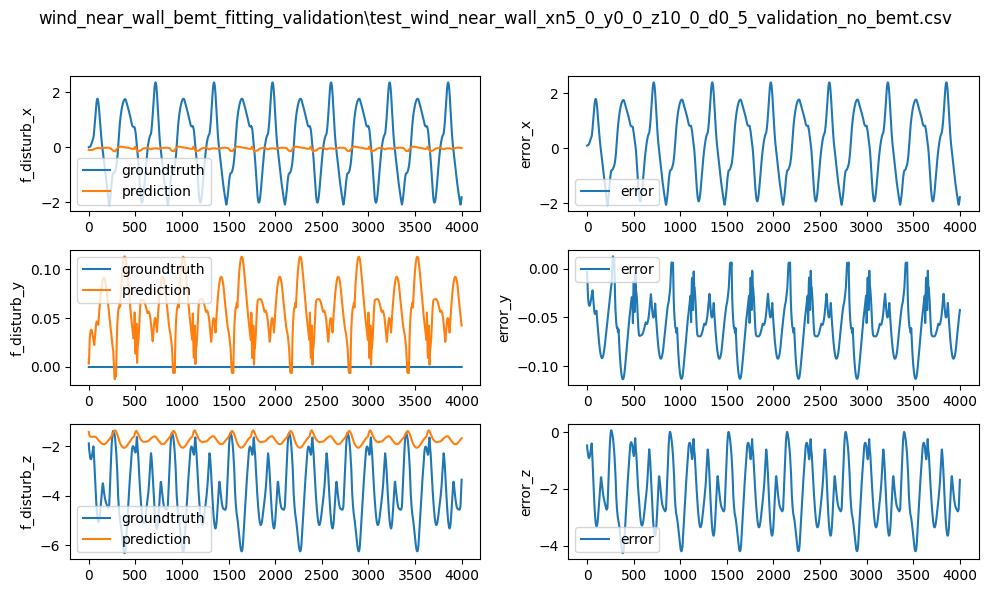

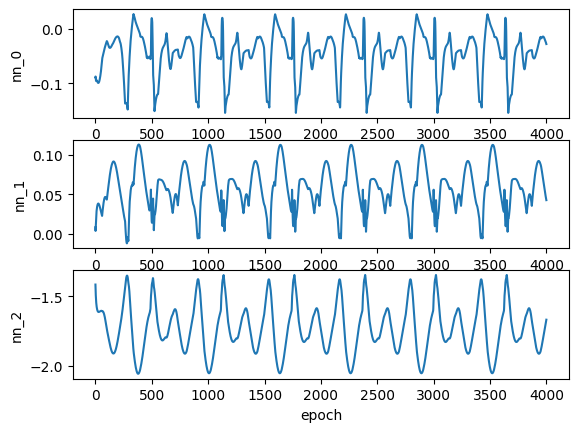

prediction: tensor([[-0.0077,  0.0085, -1.3082],
        [-0.0108,  0.0110, -1.3194],
        [-0.0132,  0.0130, -1.3286],
        ...,
        [-0.0310, -0.0016, -1.2168],
        [-0.0321, -0.0022, -1.2118],
        [-0.0333, -0.0028, -1.2071]])


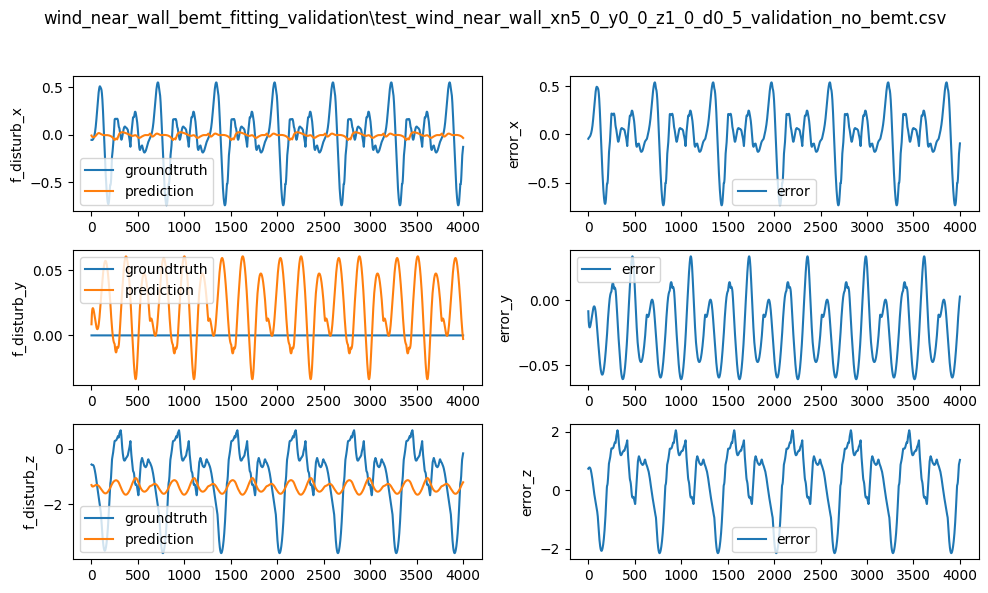

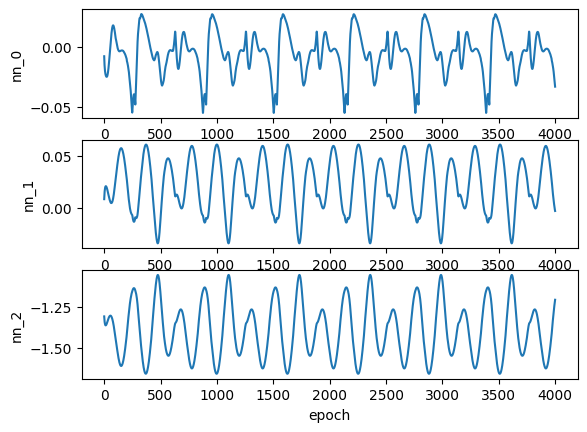

prediction: tensor([[ 6.6347e-03,  2.1976e-02, -1.4084e+00],
        [ 2.7633e-03,  2.5679e-02, -1.4260e+00],
        [-2.7855e-04,  2.8752e-02, -1.4407e+00],
        ...,
        [-1.2546e-02,  2.4495e-02, -1.3991e+00],
        [-1.3312e-02,  2.4022e-02, -1.3953e+00],
        [-1.4020e-02,  2.3549e-02, -1.3915e+00]])


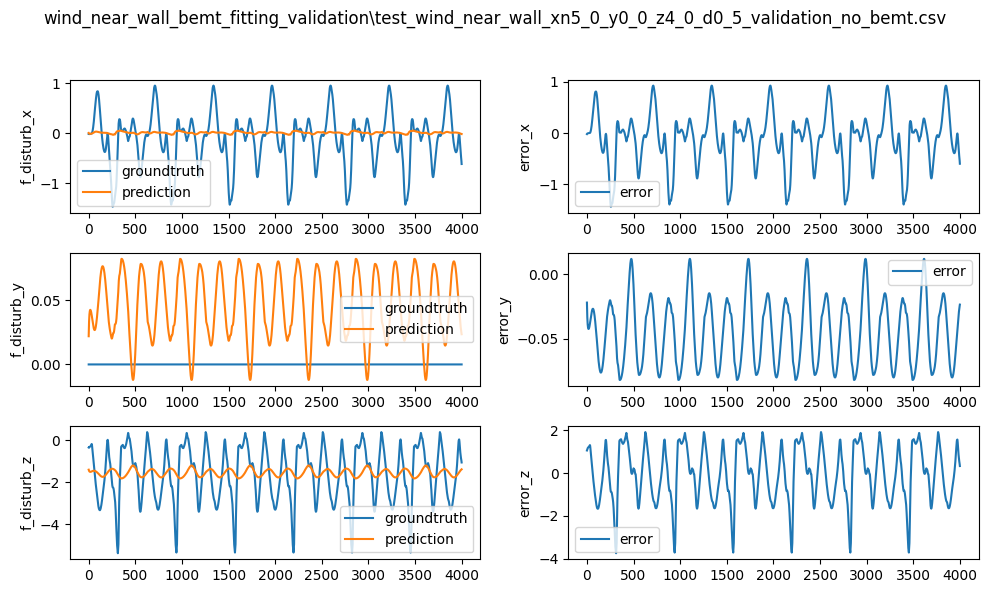

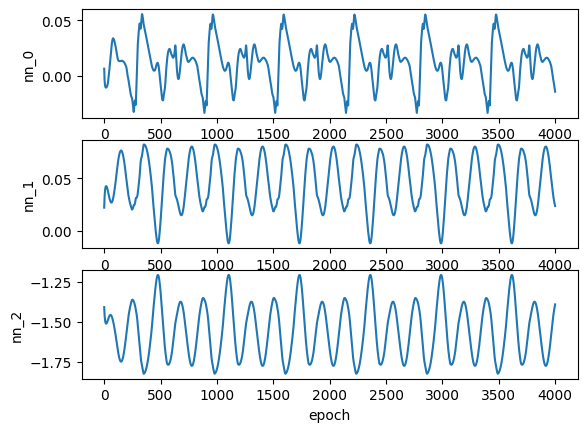

prediction: tensor([[-0.0604, -0.0408, -0.9411],
        [-0.0649, -0.0367, -0.9603],
        [-0.0681, -0.0335, -0.9757],
        ...,
        [-0.0877, -0.0470, -0.8686],
        [-0.0887, -0.0476, -0.8635],
        [-0.0897, -0.0482, -0.8585]])


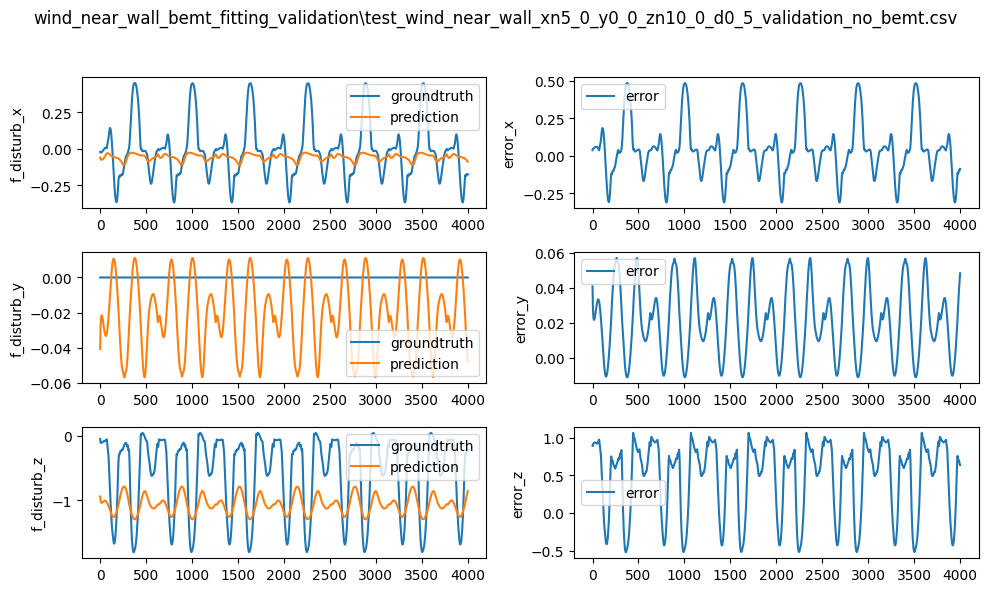

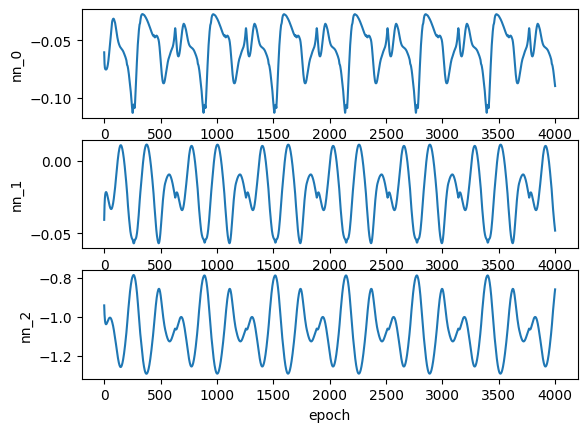

prediction: tensor([[-1.7335e-02, -4.5715e-04, -1.2414e+00],
        [-2.0355e-02,  1.2435e-03, -1.2479e+00],
        [-2.2764e-02,  2.5827e-03, -1.2529e+00],
        ...,
        [-4.3601e-02, -1.3531e-02, -1.1284e+00],
        [-4.4661e-02, -1.4004e-02, -1.1241e+00],
        [-4.5723e-02, -1.4454e-02, -1.1200e+00]])


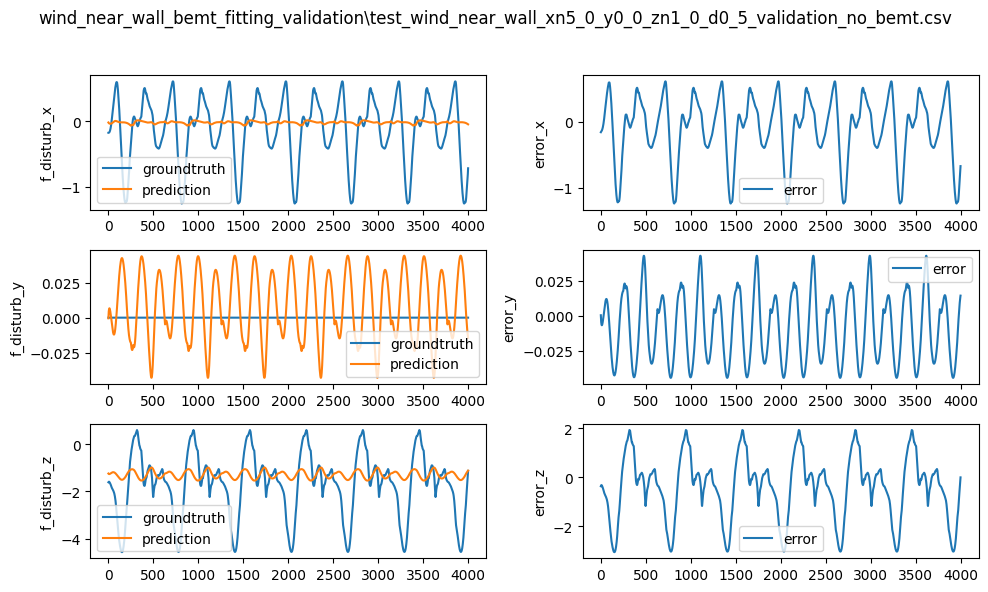

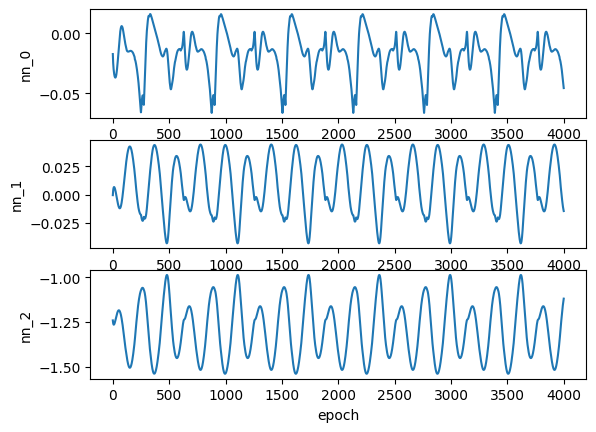

prediction: tensor([[-0.0317, -0.0139, -1.1413],
        [-0.0361, -0.0119, -1.1481],
        [-0.0394, -0.0104, -1.1530],
        ...,
        [-0.0602, -0.0307, -1.0028],
        [-0.0614, -0.0312, -0.9985],
        [-0.0625, -0.0316, -0.9943]])


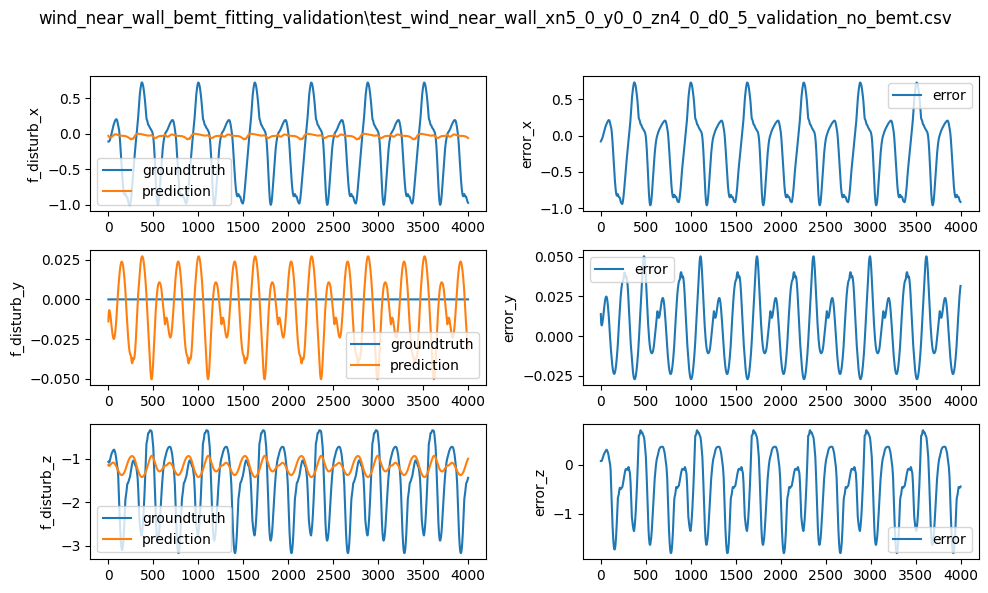

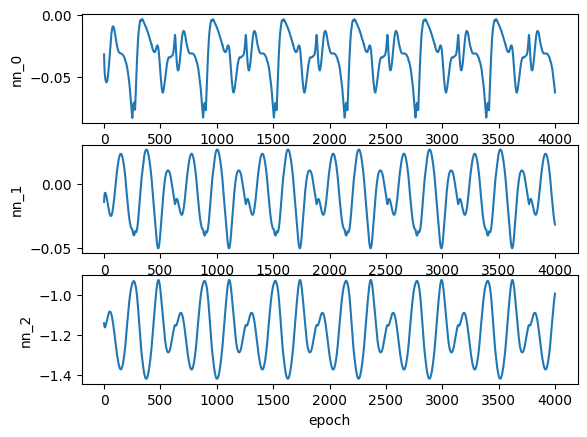

average rms for dim 0: 0.44224986703186137
average rms for dim 1: 0.037501580035824926
average rms for dim 2: 1.2906351883585447


c:\YimingVirtualDDrive\7_workSpace\repo\neural-fly\Simulation\learning\validator.py:362: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


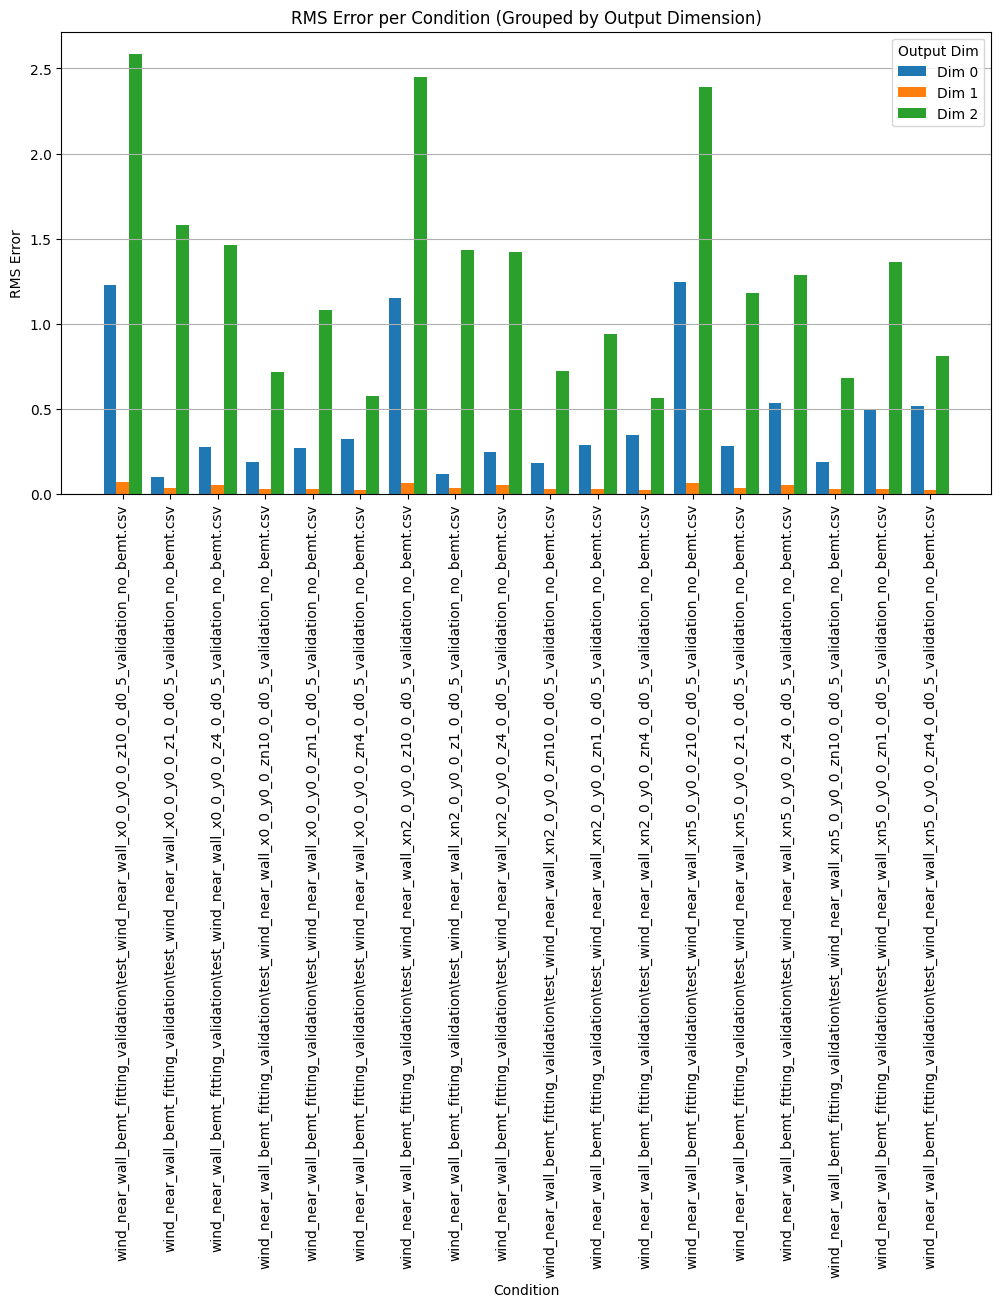

average mse for dim 0: 0.3273941943272459
average mse for dim 1: 0.0016391494359126377
average mse for dim 2: 2.047647868181472


c:\YimingVirtualDDrive\7_workSpace\repo\neural-fly\Simulation\learning\validator.py:401: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


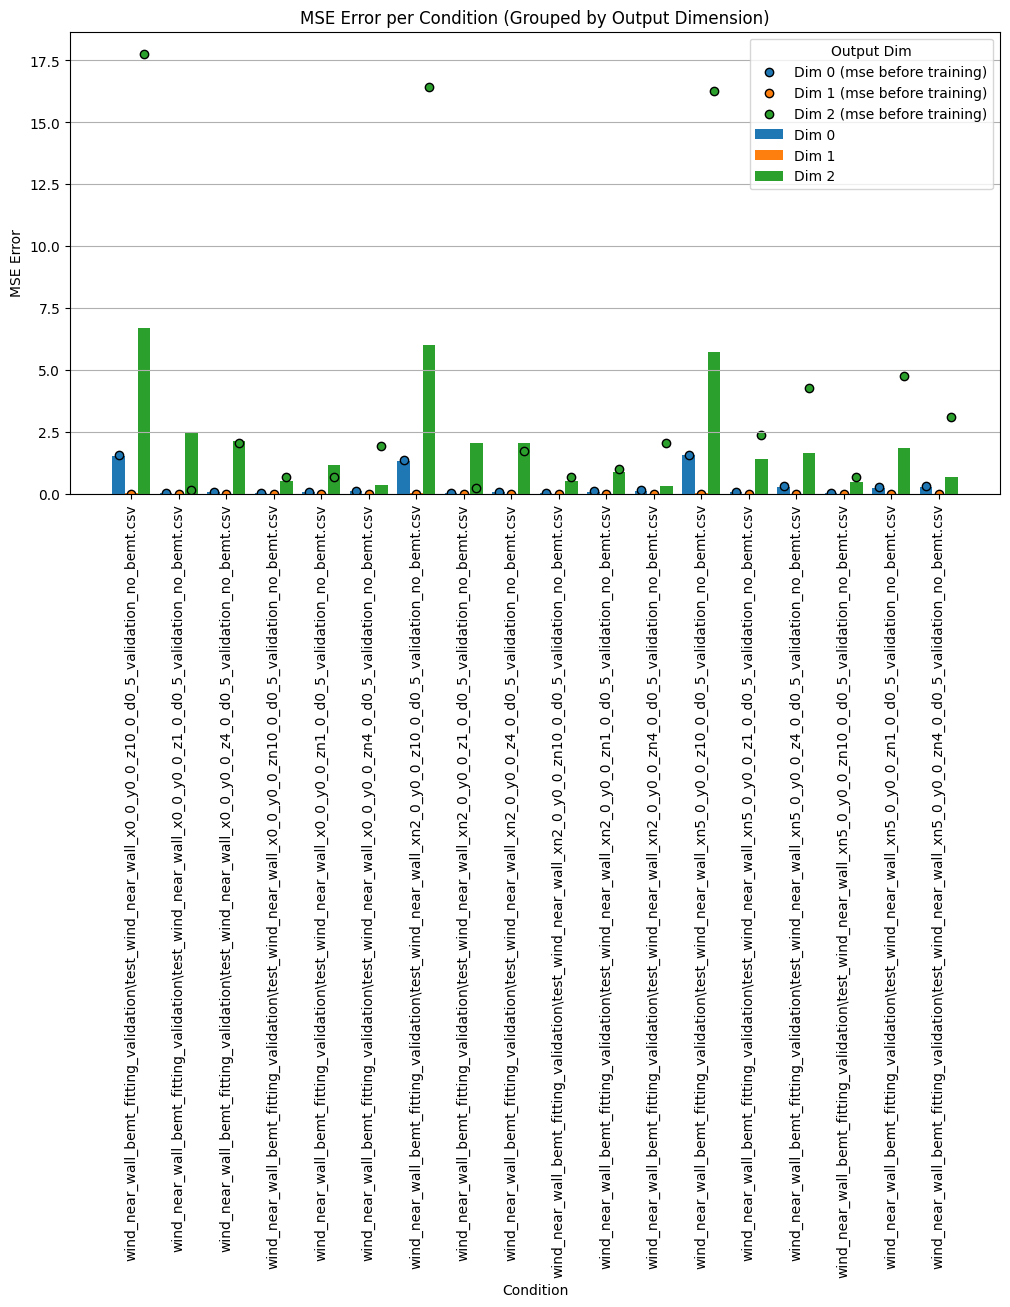

In [5]:
%matplotlib inline
model_name = training_subfolder

subfolder = validation_subfolder
# subfolder = "wind_near_wall_bemt_fitting_validation"
# subfolder = "nf_validation_back2back"
data_list = generate_data_list(subfolder)
print("test Data List:")
for data in data_list:
    print(data)

# debug
# data_list = data_list[:1]  # use small data list for quick testing

manager = factory.make_test_pipeline()

manager.set_up(
    data_menu=data_list,
    input_label_map_file=path1,
    model_name=model_name
)

# make a new trainer to replicate the above setup, just to allow verify_model to work
manager.test()
plt.show()  
